In [1]:
import os
import pandas as pd
import numpy as np
import xgboost

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import scipy.sparse as sp

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer

import gensim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("input/train_v2.csv")
test_data = pd.read_csv("input/test_v2.csv")

In [3]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


In [4]:
def read_warn_or_error_list(filename):
    with open(filename, errors='ignore') as f:
        lines = f.read().splitlines()
    _list = []
    for line in lines:
        _list.append(line.split(',')[0])
    return _list

In [5]:
success_train = 'raw_train_new/success.txt'
success_test = 'raw_test_new/success.txt'

In [6]:
success_train_list = read_warn_or_error_list(success_train)
success_test_list = read_warn_or_error_list(success_test)

In [7]:
len(success_train_list)

1376

In [8]:
len(success_test_list)

798

In [9]:
train_fulltext_list = []
for i in train_data['article_id']:
    if str(i) in success_train_list:
        filename='raw_train_new/'+str(i)+'.txt'
        with open(filename, 'r',errors='ignore') as data_file:
            train_fulltext_list.append(train_data[train_data.article_id == i].title.iloc[0]+ ' ' + data_file.read().replace('\n', ''))
    else:
        train_fulltext_list.append(train_data[train_data.article_id == i].title.iloc[0])

In [10]:
test_fulltext_list = []
for i in test_data['article_id']:
    if str(i) in success_test_list:
        filename='raw_test_new/'+str(i)+'.txt'
        with open(filename, 'r',errors='ignore') as data_file:
            test_fulltext_list.append(test_data[test_data.article_id == i].title.iloc[0]+ ' ' + data_file.read().replace('\n', ''))
    else:
        test_fulltext_list.append(test_data[test_data.article_id == i].title.iloc[0])

In [11]:
len(train_fulltext_list)

6027

In [12]:
len(test_fulltext_list)

3826

# Read in and Preprocess Data

In [13]:
def stem(sent, stemmer_type='porter'):
    '''
    stemmer_type can be porter, lancaster, or snowball
    '''
    if stemmer_type == 'porter':
        stemmer = PorterStemmer()
    elif stemmer_type == 'lancaster':
        stemmer = LancasterStemmer()
    else:
        stemmer = SnowballStemmer('english')
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([stemmer.stem(word) for word in words])

In [14]:
# #trainf='train_full_clean.txt'
# trainf='train_full.txt'
# #X = pd.read_csv(trainf,header=None,sep=",",names=['data'])
# with open(trainf) as f:
#     X = f.read().splitlines()

df = pd.DataFrame({"data": train_fulltext_list})
df = df.assign(article_id=train_data.article_id, category=train_data.category)
df.head(1)

,data,article_id,category
0,Forex - Pound drops to one-month lows against ...,1,4


In [15]:
# #trainf='train_full_clean.txt'
# trainf='test_full.txt'
# #X = pd.read_csv(trainf,header=None,sep=",",names=['data'])
# with open(trainf) as f:
#     X = f.read().splitlines()

df_test = pd.DataFrame({"data": test_fulltext_list})
df_test = df_test.assign(article_id=test_data.article_id)
df_test.head(1)

,data,article_id
0,White House plays down speedy role for US natu...,1


In [16]:
# df_noerror = df[df.article_id.isin(success_train_list)]
df_noerror = df

In [17]:
# df_test = df_test[df_test.article_id.isin(success_train_list)]

In [18]:
# perform stemming
df_noerror.loc[:, "data"] = df_noerror["data"].apply(stem)

In [19]:
df_test.loc[:, "data"] = df_test["data"].apply(stem)

In [20]:
df_noerror.shape

(6027, 3)

In [21]:
df_test.shape

(3826, 2)

In [22]:
df_noerror.head(1)

,data,article_id,category
0,forex pound drop to one month low against euro,1,4


In [23]:
df_test.head(1)

,data,article_id
0,white hous play down speedi role for us natur ...,1


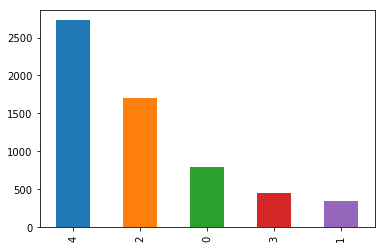

In [24]:
df_noerror.category.value_counts().plot('bar')

# Train Model

In [25]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return {'accuracy': accuracy_score(label_valid, predictions), 
            # 'f2_seperate': fbeta_score(Y_test, Y_predict, average=None, beta=2),
            'f2_macro': fbeta_score(label_valid, predictions, average='macro', beta=2),
            'f2_micro': fbeta_score(label_valid, predictions, average='micro', beta=2),
            'f2_weighted': fbeta_score(label_valid, predictions, average='weighted', beta=2)}

In [29]:
def cross_validation_data(train_data):
    X = train_data["data"].values
    y = train_data["category"].values
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        yield X_train, Y_train, X_test, Y_test

# TF-IDF

In [27]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,3), 
                                   max_df=1.0,
                                   min_df=1,
                                   max_features=8000)

tfidf_vect_ngram.fit(df_noerror["data"].tolist() + df_test["data"].tolist())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=8000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [28]:
epochs = 1

In [30]:
# Use only high confident data as extra training data
metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(df_noerror):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
    clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_test, df_test["data"]]))

    # First training using only training set
    _ = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)

    # semi supervised stage
    for epoch in range(epochs):
        # create labels
        prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
        THRESHOLD = 0.8
        mask = np.amax(prob_semi, axis=1) > THRESHOLD

        ysemi = clf.predict(xsemi_tfidf_ngram)

        print(ysemi[mask].shape)

        if epoch == epochs-1:
            # Use SVC for last epoch
            metrics = train_model(SVC(kernel='linear'),
                                  sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train, ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
#             metrics = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140),
#                               sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
#                               np.concatenate((Y_train, ysemi[mask])), 
#                               xvalid_tfidf_ngram, Y_test)
        else:
            metrics = train_model(clf,
                                  sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train, ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
    metrics_list.append(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(1781,)
(1792,)
(1814,)
(1794,)
(1694,)
(1786,)
(1806,)
(1770,)
(1742,)
(1759,)
mean accuracy: 0.6632669983416253
mean f2_macro: 0.5600644522416918
mean f2_micro: 0.6632669983416253
mean f2_weighted: 0.653240246122196



In [ ]:
# warn, epoch=1

# RF + SVC, 0.6
# 0.6749  # however does NOT improve final submission

# RF + SVC, 0.7
# 0.6753

# RF + SVC, 0.8
# 0.6744

In [88]:
# a single classifier
metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(df_noerror):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
#     clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
    clf = SVC(kernel='linear')
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    metrics = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
    
    print(metrics)
    metrics_list.append(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

{'accuracy': 0.6304347826086957, 'f2_macro': 0.46287850118195684, 'f2_micro': 0.6304347826086957, 'f2_weighted': 0.6160047086102571}
{'accuracy': 0.677536231884058, 'f2_macro': 0.5993037343164005, 'f2_micro': 0.677536231884058, 'f2_weighted': 0.6707859530901795}
{'accuracy': 0.644927536231884, 'f2_macro': 0.5323831327174694, 'f2_micro': 0.644927536231884, 'f2_weighted': 0.6377515078910662}
{'accuracy': 0.6666666666666666, 'f2_macro': 0.5351557098422033, 'f2_micro': 0.6666666666666666, 'f2_weighted': 0.6554856094981947}
{'accuracy': 0.644927536231884, 'f2_macro': 0.5331352327226447, 'f2_micro': 0.644927536231884, 'f2_weighted': 0.6334012756125253}
mean accuracy: 0.6528985507246376
mean f2_macro: 0.5325712621561349
mean f2_micro: 0.6528985507246376
mean f2_weighted: 0.6426858109404445



In [ ]:
warn

SVC
0.6730

In [90]:
# CREATE SUBMISSION

# Use only high confident data as extra training data
metrics_list = []

# clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
clf = RandomForestClassifier(n_estimators=180, criterion='entropy')

train_tfidf_ngram =  tfidf_vect_ngram.transform(df_noerror["data"])
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(df_test["data"])

# First training using only training set
_ = train_model(clf, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])

# semi supervised stage
for epoch in range(epochs):
    # create labels
    prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
    THRESHOLD = 0.6
    mask = np.amax(prob_semi, axis=1) > THRESHOLD

    ysemi = clf.predict(xsemi_tfidf_ngram)

    print(ysemi[mask].shape)

    if epoch == epochs-1:
        # Use SVC for last epoch
        final_clf = SVC(kernel='linear')
        metrics = train_model(final_clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
    else:
        metrics = train_model(clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
metrics_list.append(metrics)

print("On training set: ")
print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(462,)
On training set: 
mean accuracy: 0.7696220930232558
mean f2_macro: 0.6551242627384055
mean f2_micro: 0.7696220930232558
mean f2_weighted: 0.7614118872916578



In [91]:
df_test["category"] = final_clf.predict(xsemi_tfidf_ngram)

out = pd.DataFrame(df_test,columns=['article_id','category'])
out.to_csv('prediction_fulltext.csv',index=False)

In [70]:
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(LogisticRegression(penalty='l2', C=1.25, solver='lbfgs'), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("LR, N-Gram Vectors: ", accuracy)

LR, N-Gram Vectors:  0.6826462128475551


In [71]:
# Naive Bayes Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(MultinomialNB(alpha=0.8), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("NB, N-Gram Vectors: ", accuracy)

NB, N-Gram Vectors:  0.6586768935762224


In [30]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=160), xtrain_tfidf_ngram.tocsc(), Y_train, xvalid_tfidf_ngram.tocsc(), Y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy)

Xgb, WordLevel TF-IDF:  0.6711409395973155


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
# Random Forest on Ngram Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier(n_estimators=200, criterion='entropy'), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("RF, N-Gram Vectors: ", accuracy)

RF, N-Gram Vectors:  0.653910149750416


In [52]:
# It seems that by filtering out those in the train_warn_list, the accuracy obtained is higher.

# Create Submission Using Different Mothods

In [155]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=3000)
tfidf_vect_ngram.fit(df_noerror["data"])

train_tfidf_ngram =  tfidf_vect_ngram.transform(df_noerror["data"])
test_tfidf_ngram =  tfidf_vect_ngram.transform(df_test["data"])

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [156]:
classifier = LogisticRegression(penalty='l2', C=1.25, solver='lbfgs')
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("LR on training set ", accuracy)

LR on training set  0.7286509307234695


In [ ]:
# Naive Bayes Classifier on Ngram Level TF IDF Vectors
classifier =  MultinomialNB()
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("NB on training set ", accuracy)

In [157]:
classifier = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("XGB on training set ", accuracy)

XGB on training set  0.8842832469775475


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [163]:
classifier = RandomForestClassifier(n_estimators=180, criterion='entropy')
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("RF on training set ", accuracy)

RF on training set  0.998272884283247


In [164]:
# test_data["category"] = classifier.predict(test_tfidf_ngram.tocsc())
df_test["category"] = classifier.predict(test_tfidf_ngram)

out = pd.DataFrame(df_test,columns=['article_id','category'])
out.to_csv('prediction_fulltext.csv',index=False)

# Update prediction by title

In [94]:
df_pred = pd.read_csv('prediction.csv')
df_pred_fulltext = pd.read_csv('prediction_fulltext.csv')

In [95]:
updated_id = []
updated_cat = []
num_diff = 0
for row in df_pred.itertuples():
    updated_id.append(row.article_id)
    cat_1 = row.category
    _ls = df_pred_fulltext[df_pred_fulltext.article_id==row.article_id].category.values
   
    if _ls.size > 0:  # if calculated in fulltext prediction
        cat_2 = _ls[0]
        # print(cat_1, cat_2)
        updated_cat.append(cat_2)
        if cat_1 != cat_2:
            num_diff += 1
    else:
        updated_cat.append(cat_1)

In [96]:
df_updated = pd.DataFrame({
    'article_id': updated_id,
    'category': updated_cat
})

In [97]:
df_updated.to_csv('prediction_updated.csv',index=False)